# Project 1 
### Group #2
### Group Members: Bethany Baumann, Marcos Dominguez, Gurunadh Parinandi, Peter Prudhomme

date: 09/28/20

repo url: https://github.com/gunnuparinandi/Metis-Onl20-Ds4-Ridge-Project1/tree/master/presentation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pickle
import matplotlib.patches as mpatches

%matplotlib inline


## Initial Analysis

Create a function for MTA turnstile data import

In [3]:
def get_data(start_date, end_date):
    '''
    Returns turnstile DataFrames from the MTA website concatenated together from an input start date and end date (inclusive)
    
    Parameters:
    start_date (str): the date of the first MTA DataFrame to pull, formatted as 'mm/dd/yy'
    end_date (str): the date of the last MTA DataFrame to pull, formatted as 'mm/dd/yy'
    
    Returns:
    DataFrame: All MTA DataFrames from start date to end date concatenated together

    '''
    first_datetime_obj = datetime.strptime(first_date, '%m/%d/%y')
    last_datetime_obj = datetime.strptime(last_date, '%m/%d/%y')
    number_of_dfs = int(((last_datetime_obj - first_datetime_obj).days + 1)/7) + 1
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    date = first_datetime_obj
    for i in range(number_of_dfs):
        date = date + timedelta(7)
        string_date = date.strftime('%y') + date.strftime('%m') + date.strftime('%d')
        file_url = url.format(string_date)
        dfs.append(pd.read_csv(file_url))       
    return pd.concat(dfs)

Import 2019 data 

In [4]:
first_date = '06/01/19'
last_date = '08/24/19' #this will pull the dataset that starts on that day, so the final date row will be a week after that

df = get_data(first_date, last_date)

Or import 2020 data

In [5]:
#first_date = '05/30/20'
#last_date = '08/22/20' #this will pull the dataset that starts on that day, so the final date row will be a week after that

#df = get_data(first_date, last_date)

In [6]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,00:00:00,REGULAR,7080105,2398899
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,04:00:00,REGULAR,7080137,2398904
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,08:00:00,REGULAR,7080161,2398937
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,12:00:00,REGULAR,7080276,2399025
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,16:00:00,REGULAR,7080520,2399084


There are entries and exits values that are huge outliers (up to 2x10^9 for entries)

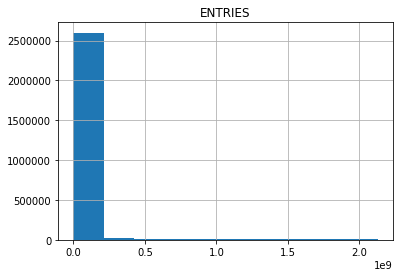

In [7]:
df.hist(column="ENTRIES");

Some of the really high values may be real, due to the ENTRIES and EXITS columns being cumulative counts

In [8]:
df[df['ENTRIES']>10000000].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
294,A002,R051,02-03-05,59 ST,NQR456W,BMT,06/01/2019,00:00:00,REGULAR,11452809,1402195
295,A002,R051,02-03-05,59 ST,NQR456W,BMT,06/01/2019,04:00:00,REGULAR,11452889,1402196
296,A002,R051,02-03-05,59 ST,NQR456W,BMT,06/01/2019,08:00:00,REGULAR,11452946,1402205
297,A002,R051,02-03-05,59 ST,NQR456W,BMT,06/01/2019,12:00:00,REGULAR,11453130,1402228
298,A002,R051,02-03-05,59 ST,NQR456W,BMT,06/01/2019,16:00:00,REGULAR,11453467,1402245


We investigated the meaning of the 'DESC' column

In [9]:
df['DESC'].value_counts()

REGULAR       2677299
RECOVR AUD      12326
Name: DESC, dtype: int64

In [10]:
df[df['DESC']=="RECOVR AUD"].sort_values('ENTRIES', ascending=False).head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
57154,N078,R175,01-03-00,14 ST,ACEL,IND,06/30/2019,21:00:00,RECOVR AUD,2129221621,1155610455
56783,N078,R175,01-03-03,14 ST,ACEL,IND,08/21/2019,09:00:00,RECOVR AUD,2129136817,1155489758
90476,N400A,R359,02-00-03,COURT SQ,EMG,IND,06/24/2019,12:00:00,RECOVR AUD,2066920942,681530044
202987,R729,R292,00-00-02,BAYCHESTER AV,5,IRT,06/04/2019,09:00:00,RECOVR AUD,2063667680,167823509
202986,R729,R292,00-00-02,BAYCHESTER AV,5,IRT,06/04/2019,05:00:00,RECOVR AUD,2063667129,167823455


For the turnstile below, we note that the entries and exits decrease as time increases. The 'recovr aud' line seems like a reasonable number here:

In [11]:
df[(df['C/A']=="N078") & (df['UNIT']=="R175") & (df['SCP']=="01-03-00") & (df['STATION']=='14 ST') & (df['DATE']=="06/30/2019")].head(7)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
57149,N078,R175,01-03-00,14 ST,ACEL,IND,06/30/2019,01:00:00,REGULAR,2129223018,1155612725
57150,N078,R175,01-03-00,14 ST,ACEL,IND,06/30/2019,05:00:00,REGULAR,2129222937,1155612683
57151,N078,R175,01-03-00,14 ST,ACEL,IND,06/30/2019,09:00:00,REGULAR,2129222905,1155612607
57152,N078,R175,01-03-00,14 ST,ACEL,IND,06/30/2019,13:00:00,REGULAR,2129222794,1155612024
57153,N078,R175,01-03-00,14 ST,ACEL,IND,06/30/2019,17:00:00,REGULAR,2129222216,1155611047
57154,N078,R175,01-03-00,14 ST,ACEL,IND,06/30/2019,21:00:00,RECOVR AUD,2129221621,1155610455


However, for other turnstiles the recovr aud entries and exits value was very different from the values around it, and we opted to remove the recovr aud rows since they were difficult to interpret and made up less than 1% of the data

In [12]:
df=df[(df['DESC']!='RECOVR AUD')]

### We focused on 
### 1) total daily entries and exits
### 2) total daily entries and exits by weekday
### 3) total daily entries and exits by weekday and time

## Analyzing Stations by Total Traffic in the 3 month Period

Column 'EXITS' has a long string of spaces in the name and we need to remove them

In [13]:
df.columns 

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [14]:
df.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

Groupby turnstile, station and date information and aggreate entries and exits columns for max and min

In [15]:
df_turnstile = df.groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE"]).agg({"ENTRIES": ['min', 'max'], "EXITS":['min', 'max']})

In [16]:
df_turnstile

ENTRIES           \
                                                           min      max   
C/A   UNIT SCP      STATION       LINENAME DATE                           
A002  R051 02-00-00 59 ST         NQR456W  06/01/2019  7080105  7080817   
                                           06/02/2019  7081001  7081567   
                                           06/03/2019  7081661  7082949   
                                           06/04/2019  7083157  7084565   
                                           06/05/2019  7084813  7086109   
...                                                        ...      ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT R        08/26/2019     5554     5554   
                                           08/27/2019     5554     5554   
                                           08/28/2019     5554     5554   
                                           08/29/2019     5554     5554   
                                           08/30/2019     5554     5554   

                                                         EXITS           
                                                           min      max  
C/A   UNIT SCP      STATION       LINENAME DATE                          
A002  R051 02-00-00 59 ST         NQR456W  06/01/2019  2398899  2399121  
                                           06/02/2019  2399154  2399319  
                                           06/03/2019  2399345  2399714  
                                           06/04/2019  2399747  2400149  
                                           06/05/2019  2400180  2400691  
...                                                        ...      ...  
TRAM2 R469 00-05-01 RIT-ROOSEVELT R        08/26/2019      386      386  
                                           08/27/2019      386      386  
                                           08/28/2019      386      386  
                                           08/29/2019      389      389  
                                           08/30/2019      389      389  

[443345 rows x 4 columns]

Create new column names from the multi-level column names

In [17]:
df_turnstile.columns.droplevel(1)
df_turnstile.columns.map(''.join)
df_turnstile.columns=df_turnstile.columns.map(''.join)

In [18]:
df_turnstile['entries_diff']=df_turnstile['ENTRIESmax']-df_turnstile['ENTRIESmin']
df_turnstile['exits_diff']=df_turnstile['EXITSmax']-df_turnstile['EXITSmin']
df_turnstile['total_people'] = df_turnstile['entries_diff']+df_turnstile['exits_diff']

Determine a maximum cuttoff for daily turnstile use to remove high outliers. We estimated this cutoff as a person using the turnstile about every 8 seconds all day

In [19]:
60*60*24/8

10800.0

In [20]:
df_turnstile = df_turnstile[df_turnstile['total_people'] < 10000]

Group the daily turnstile table by unique station (include linename)

In [21]:
df_station=df_turnstile.groupby(["STATION","LINENAME"])[['total_people']].sum()

Print table of top ten trafficked stations

In [22]:
top_ten=df_station.sort_values('total_people', ascending=False).head(10)
top_ten

,,total_people
STATION,LINENAME,
GRD CNTRL-42 ST,4567S,18279051
34 ST-HERALD SQ,BDFMNQRW,16057696
34 ST-PENN STA,ACE,11142187
42 ST-PORT AUTH,ACENQRS1237W,10511619
14 ST-UNION SQ,LNQR456W,9064092
TIMES SQ-42 ST,1237ACENQRSW,8857418
FULTON ST,2345ACJZ,8834286
47-50 STS ROCK,BDFM,8355390
FLUSHING-MAIN,7,7438357


Load in the pickle file of stations matched to location data

In [23]:
with open("station_locations_correct_2.pickle",'rb') as read_file:
    locations=pickle.load(read_file)

Merge the locations data table with the total traffick per station table

In [24]:
plotdata = pd.merge(left=locations, right=df_station, how="left", left_on=["STATION", "LINENAME"], right_on=["STATION", "LINENAME"])

Plot a scatterplot with longitude/latitude for each station and its total people in the time period as a colormap intensity

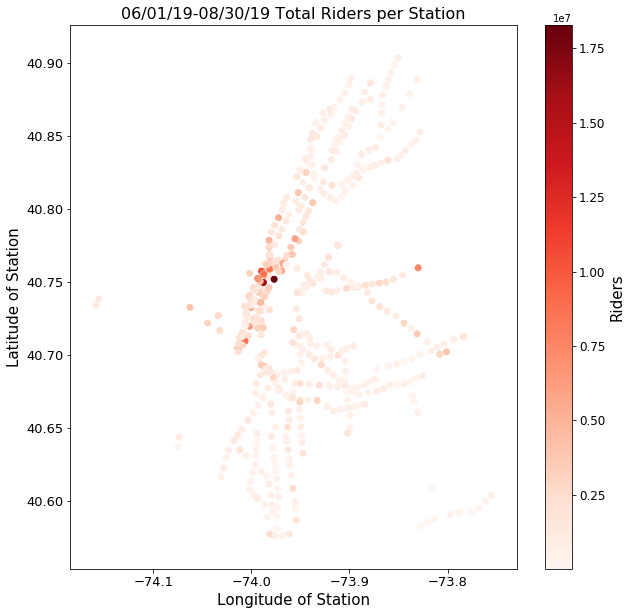

In [25]:
plt.figure(figsize=[10,10])
plt.scatter(x= plotdata["GTFS Longitude"],cmap= "Reds", y=plotdata["GTFS Latitude"], c=plotdata["total_people"])

plt.title('06/01/19-08/30/19 Total Riders per Station',fontsize = 16)
#plt.title("05/30/19-08/29/20 Total Riders per Station", fontsize=20)
plt.xlabel('Longitude of Station', fontsize=15)
plt.ylabel('Latitude of Station',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

#Add the colorbar
cbar = plt.colorbar()
cbar.set_label(label='Riders',size=15)
cbar.ax.tick_params(labelsize=12) 

plt.savefig("subway_heatmap_2019_3month_2.jpg")

In [26]:
top=plotdata.sort_values('total_people', ascending=False).head(12)
top

,STATION,LINENAME,DIVISION,index,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,STATION.1,total_people
402,GRD CNTRL-42 ST,4567S,IRT,402,402,610,631,IRT,Lexington Av,Grand Central - 42 St,M,456,Subway,40.751776,-73.976848,Uptown & The Bronx,Downtown & Brooklyn,GRAND CENTRAL - 42 ST,18279051.0
161,34 ST-HERALD SQ,BDFMNQRW,IND,11,12,607,R17,BMT,Broadway - Brighton,34 St - Herald Sq,M,NQRW,Subway,40.749567,-73.987950,Uptown & Queens,Downtown & Brooklyn,34 ST - HERALD SQ,16057696.0
15,34 ST-HERALD SQ,BDFMNQRW,BMT,11,12,607,R17,BMT,Broadway - Brighton,34 St - Herald Sq,M,NQRW,Subway,40.749567,-73.987950,Uptown & Queens,Downtown & Brooklyn,34 ST - HERALD SQ,16057696.0
162,34 ST-PENN STA,ACE,IND,163,164,164,A28,IND,8th Av - Fulton St,34 St - Penn Station,M,ACE,Subway,40.752287,-73.993391,Uptown - Queens,Downtown & Brooklyn,34 ST - PENN STATION,11142187.0
167,42 ST-PORT AUTH,ACENQRS1237W,IND,464,163,611,A27,IND,8th Av - Fulton St,42 St - Port Authority Bus Terminal,M,ACE,Subway,40.757308,-73.989735,Uptown - Queens,Downtown & Brooklyn,42 ST - PORT AUTHORITY BUS TERMINAL,10511619.0
4,14 ST-UNION SQ,LNQR456W,BMT,14,15,602,R20,BMT,Broadway - Brighton,14 St - Union Sq,M,NQRW,Subway,40.735736,-73.990568,Uptown & Queens,Downtown & Brooklyn,14 ST - UNION SQ,9064092.0
448,TIMES SQ-42 ST,1237ACENQRSW,IRT,10,317,611,127,IRT,Broadway - 7Av,Times Sq - 42 St,M,123,Subway,40.755290,-73.987495,Uptown & The Bronx,Downtown & Brooklyn,TIMES SQ - 42 ST,8857418.0
400,FULTON ST,2345ACJZ,IRT,105,332,628,229,IRT,Clark St,Fulton St,M,23,Subway,40.709416,-74.006571,Uptown & The Bronx,Downtown & Brooklyn,FULTON ST,8834286.0
235,FULTON ST,2345ACJZ,IND,105,172,628,A38,IND,8th Av - Fulton St,Fulton St,M,AC,Subway,40.710197,-74.007691,Uptown,Brooklyn,FULTON ST,8834286.0
169,47-50 STS ROCK,BDFM,IND,225,225,225,D15,IND,6th Av - Culver,47-50 Sts - Rockefeller Ctr,M,BDFM,Subway,40.758663,-73.981329,Uptown & The Bronx - Queens,Downtown & Brooklyn,47-50 STS - ROCKEFELLER CTR,8355390.0


Some duplicates exist in the table above (same station, line, and total people, but different division), I chose the non-duplicate rows for graphing below

In [27]:
top=top.loc[[402,161,162,167,4,448,400,169,395,475]]

In [28]:
##For 2020 data
#top=top.loc[[161,402,167,395,251,162,247,4,400,355]]
#Dates in plot titles should also be changed for 2020 

Create a bar plot of the top ten trafficked stations during this time period, with colors depending on borough

In [29]:
plotdata["Borough"].unique()

array(['M', 'Q', 'Bk', 'Bx', 'SI'], dtype=object)

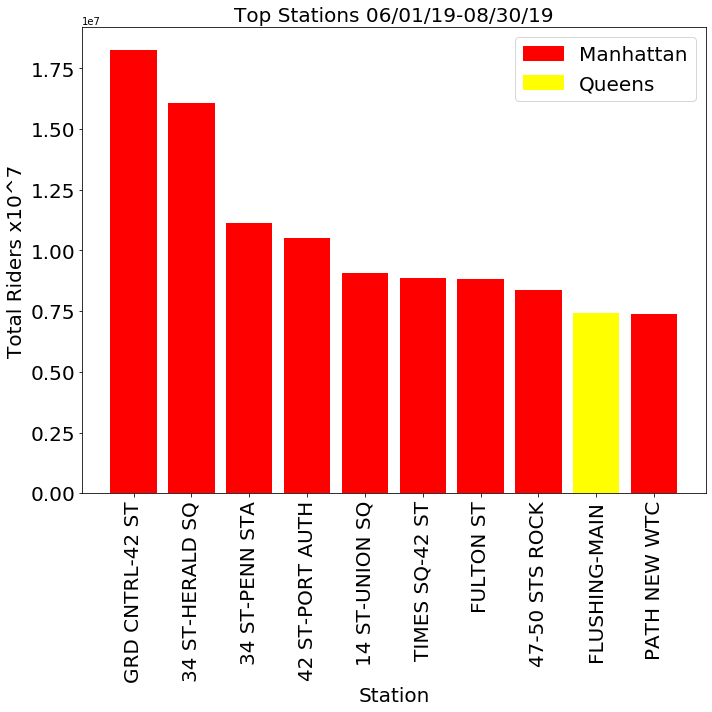

In [30]:
plt.figure(figsize=[10,10])
colors = {'M':'red', 'Bk':'blue', 'Bx':'green', 'Q':'yellow'}

plt.bar(x=top["STATION"],height=top["total_people"],color=top["Borough"].apply(lambda x: colors[x]))
plt.title("Top Stations 06/01/19-08/30/19", fontsize=20)
#plt.title("Top Stations 05/30/19-08/29/20", fontsize=20)
plt.xlabel("Station", fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.ylabel("Total Riders x10^7", fontsize=20)
plt.yticks(fontsize=20)

#Add the legend
M = mpatches.Patch(color='red', label='Manhattan')
Q = mpatches.Patch(color='yellow', label='Queens')
plt.legend(handles=[M,Q], fontsize=20)
plt.tight_layout()

plt.savefig("2019_top_biggerfont.jpg");

## Analyzing Stations by Weekdays

Below we create a column in the data set that corresponds to day of the week

In [31]:
df['DATETIME'] = pd.to_datetime(df['DATE']+' '+df['TIME'])
df['DAY OF WEEK'] = df['DATETIME'].apply(lambda dt_object: dt_object.strftime('%A'))

In [32]:
df['DAY OF WEEK'].value_counts() #checking row counts by date to make sure there's an even distribution

Tuesday      385601
Friday       384884
Wednesday    384583
Monday       382894
Thursday     382563
Saturday     378579
Sunday       378195
Name: DAY OF WEEK, dtype: int64

In [33]:
df_by_days = df.groupby(["C/A", "UNIT", "SCP", "STATION", 'LINENAME',"DAY OF WEEK"]).agg({"ENTRIES": ['min', 'max'], "EXITS":['min', 'max']})
df_by_days

ENTRIES           \
                                                            min      max   
C/A   UNIT SCP      STATION       LINENAME DAY OF WEEK                     
A002  R051 02-00-00 59 ST         NQR456W  Friday       7087917  7183072   
                                           Monday       7081661  7178703   
                                           Saturday     7080105  7177221   
                                           Sunday       7081001  7177677   
                                           Thursday     7086363  7182025   
...                                                         ...      ...   
TRAM2 R469 00-05-01 RIT-ROOSEVELT R        Saturday        5554     5554   
                                           Sunday          5554     5554   
                                           Thursday        5554     5554   
                                           Tuesday         5554     5554   
                                           Wednesday       5554     5554   

                                                          EXITS           
                                                            min      max  
C/A   UNIT SCP      STATION       LINENAME DAY OF WEEK                    
A002  R051 02-00-00 59 ST         NQR456W  Friday       2401244  2433115  
                                           Monday       2399345  2431195  
                                           Saturday     2398899  2430563  
                                           Sunday       2399154  2430762  
                                           Thursday     2400727  2432742  
...                                                         ...      ...  
TRAM2 R469 00-05-01 RIT-ROOSEVELT R        Saturday         378      386  
                                           Sunday           379      386  
                                           Thursday         379      389  
                                           Tuesday          379      386  
                                           Wednesday        379      386  

[34441 rows x 4 columns]

In [34]:
def get_total_people(dataframe):
    '''
    Returns turnstile dataframe with added columns for max/min of entries and exits per day and then summed to give the 
    total amount of people at a given station. Then filters the dataframe to show only rows with under
    10,000 counts (the physical limit of a person going through a turnstile every ten seconds for a day)
    
    Parameters:
    dataframe (DataFrame): Turnstile dataframe (must already be grouped by unique turnstiles and day of week or date) 
        
    Returns:
    dataframe (DataFrame): Turnstile dataframe with added columns

    '''

    dataframe.columns.droplevel(1)
    dataframe.columns.map(''.join)
    dataframe.columns=dataframe.columns.map(''.join)
    dataframe['entries_diff']=dataframe['ENTRIESmax']-dataframe['ENTRIESmin']
    dataframe['exits_diff']=dataframe['EXITSmax']-dataframe['EXITSmin']
    dataframe['total_people'] = dataframe['entries_diff']+dataframe['exits_diff']
    dataframe = dataframe[dataframe['total_people'] < 10000]
    
    return dataframe



In [35]:
df_days_total_people = get_total_people(df_by_days)

In [36]:
df_days_total_people.sort_values('total_people')

ENTRIESmin  \
C/A   UNIT SCP      STATION         LINENAME DAY OF WEEK               
N193  R337 00-05-01 BEACH 44 ST     A        Sunday                1   
N416  R286 01-05-01 MYRTLE-WILLOUGH G        Monday                0   
                                             Friday                0   
N192  R336 00-05-01 BEACH 60 ST     A        Sunday                1   
                                             Thursday              1   
...                                                              ...   
R618  R058 01-06-00 BERGEN ST       23       Wednesday        188795   
A011  R080 01-03-03 57 ST-7 AV      NQRW     Thursday              0   
R532  R328 00-06-02 METS-WILLETS PT 7        Saturday         115870   
R618  R058 01-06-00 BERGEN ST       23       Saturday         188788   
R532H R328 02-03-06 METS-WILLETS PT 7        Wednesday        136139   

                                                          ENTRIESmax  \
C/A   UNIT SCP      STATION         LINENAME DAY OF WEEK               
N193  R337 00-05-01 BEACH 44 ST     A        Sunday                1   
N416  R286 01-05-01 MYRTLE-WILLOUGH G        Monday                0   
                                             Friday                0   
N192  R336 00-05-01 BEACH 60 ST     A        Sunday                1   
                                             Thursday              1   
...                                                              ...   
R618  R058 01-06-00 BERGEN ST       23       Wednesday        189052   
A011  R080 01-03-03 57 ST-7 AV      NQRW     Thursday           3299   
R532  R328 00-06-02 METS-WILLETS PT 7        Saturday         123768   
R618  R058 01-06-00 BERGEN ST       23       Saturday         189038   
R532H R328 02-03-06 METS-WILLETS PT 7        Wednesday        140587   

                                                          EXITSmin  EXITSmax  \
C/A   UNIT SCP      STATION         LINENAME DAY OF WEEK                       
N193  R337 00-05-01 BEACH 44 ST     A        Sunday            203       203   
N416  R286 01-05-01 MYRTLE-WILLOUGH G        Monday            275       275   
                                             Friday            275       275   
N192  R336 00-05-01 BEACH 60 ST     A        Sunday            100       100   
                                             Thursday          100       100   
...                                                            ...       ...   
R618  R058 01-06-00 BERGEN ST       23       Wednesday     1566501   1575979   
A011  R080 01-03-03 57 ST-7 AV      NQRW     Thursday            1      6448   
R532  R328 00-06-02 METS-WILLETS PT 7        Saturday        29115     30974   
R618  R058 01-06-00 BERGEN ST       23       Saturday      1566033   1575562   
R532H R328 02-03-06 METS-WILLETS PT 7        Wednesday      140160    145677   

                                                          entries_diff  \
C/A   UNIT SCP      STATION         LINENAME DAY OF WEEK                 
N193  R337 00-05-01 BEACH 44 ST     A        Sunday                  0   
N416  R286 01-05-01 MYRTLE-WILLOUGH G        Monday                  0   
                                             Friday                  0   
N192  R336 00-05-01 BEACH 60 ST     A        Sunday                  0   
                                             Thursday                0   
...                                                                ...   
R618  R058 01-06-00 BERGEN ST       23       Wednesday             257   
A011  R080 01-03-03 57 ST-7 AV      NQRW     Thursday             3299   
R532  R328 00-06-02 METS-WILLETS PT 7        Saturday             7898   
R618  R058 01-06-00 BERGEN ST       23       Saturday              250   
R532H R328 02-03-06 METS-WILLETS PT 7        Wednesday            4448   

                                                          exits_diff  \
C/A   UNIT SCP      STATION         LINENAME DAY OF WEEK               
N193  R337 00-05-01 BEACH 44 ST     

In [37]:
df_days_total_people = df_days_total_people.groupby(['DAY OF WEEK'])[['total_people']].sum()

In [38]:
organized_days = df_days_total_people.reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

organized_days #the total people (over 3 month period) through all stations by day of the week

,total_people
DAY OF WEEK,
Sunday,298179
Monday,309247
Tuesday,308331
Wednesday,276069
Thursday,265196
Friday,268013
Saturday,313356


<Figure size 432x288 with 0 Axes>

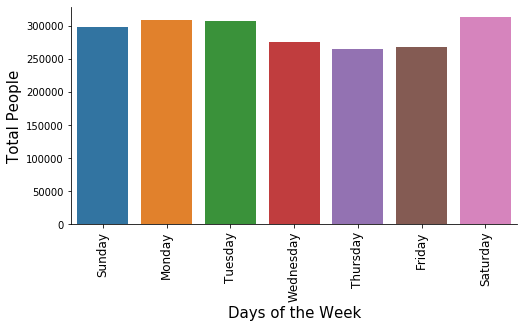

In [39]:
plt.tight_layout()
plt.subplots(figsize=(8,4))
sns.barplot(x = organized_days['total_people'].index.tolist(),y='total_people',data=organized_days);
sns.despine()
plt.xlabel('Days of the Week', fontsize =15)
plt.ylabel('Total People', fontsize = 15)
plt.xticks(rotation='vertical', fontsize = 12)

plt.savefig('myfile.png', bbox_inches = "tight")


In [40]:
ungrouped_df = df_by_days.reset_index()
ungrouped_df

,C/A,UNIT,SCP,STATION,LINENAME,DAY OF WEEK,ENTRIESmin,ENTRIESmax,EXITSmin,EXITSmax,entries_diff,exits_diff,total_people
0,A002,R051,02-00-00,59 ST,NQR456W,Friday,7087917,7183072,2401244,2433115,95155,31871,127026
1,A002,R051,02-00-00,59 ST,NQR456W,Monday,7081661,7178703,2399345,2431195,97042,31850,128892
2,A002,R051,02-00-00,59 ST,NQR456W,Saturday,7080105,7177221,2398899,2430563,97116,31664,128780
3,A002,R051,02-00-00,59 ST,NQR456W,Sunday,7081001,7177677,2399154,2430762,96676,31608,128284
4,A002,R051,02-00-00,59 ST,NQR456W,Thursday,7086363,7182025,2400727,2432742,95662,32015,127677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34436,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,Saturday,5554,5554,378,386,0,8,8
34437,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,Sunday,5554,5554,379,386,0,7,7
34438,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,Thursday,5554,5554,379,389,0,10,10
34439,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,Tuesday,5554,5554,379,386,0,7,7


In [41]:
df_grn_cntrl = ungrouped_df[(ungrouped_df['STATION'] == 'GRD CNTRL-42 ST') & (ungrouped_df['LINENAME'] == '4567S')
                            ].groupby(['DAY OF WEEK'])[['total_people']].sum()
df_grn_cntrl.sort_values('total_people', ascending = False) #looking at ONLY grand centrl/45675

,total_people
DAY OF WEEK,
Monday,2814703672
Thursday,2810857287
Friday,2810803979
Wednesday,2810426775
Tuesday,2810422102
Saturday,2808425752
Sunday,2808359403


In [42]:
def get_most_pop_DOW(station, linename):
    '''
    Returns the day with the highest total_people for a given station/linename
    
    Parameters:
    station (str): station
    linename(str): linename
    
    Returns:
    str: Day of week with the highest total_people
    '''
    days_df = ungrouped_df[(ungrouped_df['STATION'] == station) & (ungrouped_df['LINENAME'] == linename)
                          ].groupby(['DAY OF WEEK'])[['total_people']].sum()
    days_df.sort_values('total_people', ascending = False, inplace = True)
    return days_df.index[0]


In [43]:
STATION = 'FULTON ST'
LINENAME = '2345ACJZ'

get_most_pop_DOW(STATION, LINENAME)

'Monday'

In [44]:
df_by_date = df.groupby(["C/A", "UNIT", "SCP", "STATION", 'LINENAME',"DATE"]).agg({"ENTRIES": ['min', 'max'], "EXITS":['min', 'max']})


In [45]:
df_by_date = get_total_people(df_by_date)

In [46]:
df_by_date.sort_values('total_people')

ENTRIESmin  \
C/A   UNIT SCP      STATION         LINENAME     DATE                     
TRAM2 R469 00-05-01 RIT-ROOSEVELT   R            08/30/2019        5554   
R117  R343 00-00-02 FRANKLIN ST     1            06/27/2019    11095671   
                                                 06/29/2019    11095673   
                                                 06/30/2019    11095673   
                                                 07/01/2019    11095673   
...                                                                 ...   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 06/21/2019  1280131971   
                                                 06/19/2019  1280124058   
R240  R047 00-00-01 GRD CNTRL-42 ST 4567S        08/01/2019     1091738   
R161A R452 01-00-00 72 ST           123          08/06/2019      352959   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 08/28/2019  1280360940   

                                                             ENTRIESmax  \
C/A   UNIT SCP      STATION         LINENAME     DATE                     
TRAM2 R469 00-05-01 RIT-ROOSEVELT   R            08/30/2019        5554   
R117  R343 00-00-02 FRANKLIN ST     1            06/27/2019    11095671   
                                                 06/29/2019    11095673   
                                                 06/30/2019    11095673   
                                                 07/01/2019    11095673   
...                                                                 ...   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 06/21/2019  1280135617   
                                                 06/19/2019  1280127635   
R240  R047 00-00-01 GRD CNTRL-42 ST 4567S        08/01/2019     1096181   
R161A R452 01-00-00 72 ST           123          08/06/2019      355389   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 08/28/2019  1280364226   

                                                              EXITSmin  \
C/A   UNIT SCP      STATION         LINENAME     DATE                    
TRAM2 R469 00-05-01 RIT-ROOSEVELT   R            08/30/2019        389   
R117  R343 00-00-02 FRANKLIN ST     1            06/27/2019    3179940   
                                                 06/29/2019    3179941   
                                                 06/30/2019    3179941   
                                                 07/01/2019    3179941   
...                                                                ...   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 06/21/2019  176372068   
                                                 06/19/2019  176356932   
R240  R047 00-00-01 GRD CNTRL-42 ST 4567S        08/01/2019    1240417   
R161A R452 01-00-00 72 ST           123          08/06/2019    1367497   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 08/28/2019  176782032   

                                                              EXITSmax  \
C/A   UNIT SCP      STATION         LINENAME     DATE                    
TRAM2 R469 00-05-01 RIT-ROOSEVELT   R            08/30/2019        389   
R117  R343 00-00-02 FRANKLIN ST     1            06/27/2019    3179940   
                                                 06/29/2019    3179941   
                                                 06/30/2019    3179941   
                                                 07/01/2019    3179941   
...                                                                ...   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 06/21/2019  176378409   
                                                 06/19/2019  176363346   
R240  R047 00-00-01 GRD CNTRL-42 ST 4567S        08/01/2019    1245965   
R161A R452 01-00-00 72 ST           123          08/06/2019    1375059   
N063A R011 00-00-01 42 ST-PORT AUTH ACENQRS1237W 08/28/2019  176788741   

                                                             entries_diff  \
C/A   UNIT SCP      STATION         LINENAME     DATE                       
TRAM2 R469 00-05-01 RIT-ROOSE

In [47]:
total_people_by_location = df_by_date.groupby(["STATION", 'LINENAME'])[['total_people']].sum()

In [48]:
total_people_by_location.sort_values('total_people')

,,total_people
STATION,LINENAME,
ORCHARD BEACH,6,10534
BROAD CHANNEL,AS,31211
TOMPKINSVILLE,1,48257
BEACH 105 ST,AS,71065
BEACH 44 ST,A,108901
...,...,...
14 ST-UNION SQ,LNQR456W,9064092
42 ST-PORT AUTH,ACENQRS1237W,10511619
34 ST-PENN STA,ACE,11142187


In [49]:
top_ten = total_people_by_location.sort_values('total_people', ascending=False).head(10)

In [50]:
top_ten

,,total_people
STATION,LINENAME,
GRD CNTRL-42 ST,4567S,18279051
34 ST-HERALD SQ,BDFMNQRW,16057696
34 ST-PENN STA,ACE,11142187
42 ST-PORT AUTH,ACENQRS1237W,10511619
14 ST-UNION SQ,LNQR456W,9064092
TIMES SQ-42 ST,1237ACENQRSW,8857418
FULTON ST,2345ACJZ,8834286
47-50 STS ROCK,BDFM,8355390
FLUSHING-MAIN,7,7438357


In [51]:
top_ten_list = top_ten.index

In [52]:
top_ten_list

MultiIndex([('GRD CNTRL-42 ST',        '4567S'),
            ('34 ST-HERALD SQ',     'BDFMNQRW'),
            ( '34 ST-PENN STA',          'ACE'),
            ('42 ST-PORT AUTH', 'ACENQRS1237W'),
            ( '14 ST-UNION SQ',     'LNQR456W'),
            ( 'TIMES SQ-42 ST', '1237ACENQRSW'),
            (      'FULTON ST',     '2345ACJZ'),
            ( '47-50 STS ROCK',         'BDFM'),
            (  'FLUSHING-MAIN',            '7'),
            (   'PATH NEW WTC',            '1')],
           names=['STATION', 'LINENAME'])

In [53]:
recommendations = []
for location in top_ten_list:
    recommendations.append(get_most_pop_DOW(location[0], location[1]))

recommendations

['Monday',
 'Thursday',
 'Monday',
 'Friday',
 'Tuesday',
 'Wednesday',
 'Monday',
 'Wednesday',
 'Friday',
 'Tuesday']

In [54]:
highest_traffic_df = pd.DataFrame(recommendations, index = top_ten_list, columns = ['highest_traffic_day'])

In [55]:
highest_traffic_df

,,highest_traffic_day
STATION,LINENAME,
GRD CNTRL-42 ST,4567S,Monday
34 ST-HERALD SQ,BDFMNQRW,Thursday
34 ST-PENN STA,ACE,Monday
42 ST-PORT AUTH,ACENQRS1237W,Friday
14 ST-UNION SQ,LNQR456W,Tuesday
TIMES SQ-42 ST,1237ACENQRSW,Wednesday
FULTON ST,2345ACJZ,Monday
47-50 STS ROCK,BDFM,Wednesday
FLUSHING-MAIN,7,Friday


In [56]:
table = pd.concat([top_ten, highest_traffic_df], axis = 1)

In [57]:
table.columns = ['TOTAL TRAFFIC (OVER THREE MONTHS)', 'HIGHEST TRAFFIC DAY']

In [58]:
table

,,TOTAL TRAFFIC (OVER THREE MONTHS),HIGHEST TRAFFIC DAY
STATION,LINENAME,,
GRD CNTRL-42 ST,4567S,18279051,Monday
34 ST-HERALD SQ,BDFMNQRW,16057696,Thursday
34 ST-PENN STA,ACE,11142187,Monday
42 ST-PORT AUTH,ACENQRS1237W,10511619,Friday
14 ST-UNION SQ,LNQR456W,9064092,Tuesday
TIMES SQ-42 ST,1237ACENQRSW,8857418,Wednesday
FULTON ST,2345ACJZ,8834286,Monday
47-50 STS ROCK,BDFM,8355390,Wednesday
FLUSHING-MAIN,7,7438357,Friday


## Analyzing Top Stations Traffic by Time

Group by turnstiles together

In [59]:
turnstiles_daily = (df.groupby(["C/A", "UNIT", "SCP", "STATION", 'LINENAME', "DATETIME", "TIME"],as_index=False)
                        ['ENTRIES', 'EXITS'].first())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [60]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 00:00:00,00:00:00,7080105,2398899
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 04:00:00,04:00:00,7080137,2398904
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 08:00:00,08:00:00,7080161,2398937
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 12:00:00,12:00:00,7080276,2399025
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 16:00:00,16:00:00,7080520,2399084


Add Previous Entries and Previous Exits columns, indicating the previous hour's value. Then, we shift these columns
up to line up previous entries/exits with entries/exits so we can take the difference and get daily entries/exits

In [61]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES", 'PREV_EXITS']] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME"])["DATETIME", "ENTRIES", 'EXITS']
                                                       .apply(lambda grp: grp.shift(1)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [62]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 00:00:00,00:00:00,7080105,2398899,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 04:00:00,04:00:00,7080137,2398904,2019-06-01 00:00:00,7080105.0,2398899.0
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 08:00:00,08:00:00,7080161,2398937,2019-06-01 04:00:00,7080137.0,2398904.0
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 12:00:00,12:00:00,7080276,2399025,2019-06-01 08:00:00,7080161.0,2398937.0
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 16:00:00,16:00:00,7080520,2399084,2019-06-01 12:00:00,7080276.0,2399025.0


Drop the rows for the earliest date in the df to remove NaT values

In [63]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [64]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 04:00:00,04:00:00,7080137,2398904,2019-06-01 00:00:00,7080105.0,2398899.0
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 08:00:00,08:00:00,7080161,2398937,2019-06-01 04:00:00,7080137.0,2398904.0
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 12:00:00,12:00:00,7080276,2399025,2019-06-01 08:00:00,7080161.0,2398937.0
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 16:00:00,16:00:00,7080520,2399084,2019-06-01 12:00:00,7080276.0,2399025.0
5,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 20:00:00,20:00:00,7080817,2399121,2019-06-01 16:00:00,7080520.0,2399084.0


Look for rows where Previous Entry/Exit > Entry/Exit. These could be a glitch in the system. This wasn't an issue when using daily max and min per turnstile, but it is when looking at times

In [65]:
turnstiles_daily[(turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]) |
                 (turnstiles_daily["EXITS"] < turnstiles_daily["PREV_EXITS"])].head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
6216,A002,R051,02-06-00,59 ST,NQR456W,2019-07-13 12:00:00,12:00:00,113,11,2019-07-13 04:00:00,258249.0,8218.0
12028,A007,R079,01-05-01,5 AV/59 ST,NQRW,2019-08-05 14:00:00,14:00:00,0,2,2019-08-04 22:00:00,1.0,1299.0
21534,A011,R080,01-03-00,57 ST-7 AV,NQRW,2019-08-16 11:58:07,11:58:07,885829659,490361269,2019-08-16 08:00:00,885829659.0,490361274.0
21537,A011,R080,01-03-00,57 ST-7 AV,NQRW,2019-08-16 13:18:07,13:18:07,885829659,490361267,2019-08-16 12:00:00,885829659.0,490361269.0
21550,A011,R080,01-03-00,57 ST-7 AV,NQRW,2019-08-18 12:00:00,12:00:00,885829659,490361266,2019-08-18 08:00:00,885829659.0,490361267.0


Let's see how many stations have this problem

In [66]:
(turnstiles_daily[(turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]) | 
                  (turnstiles_daily["EXITS"] < turnstiles_daily["PREV_EXITS"])]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A002  R051  02-06-00  59 ST                1
A007  R079  01-05-01  5 AV/59 ST           1
A011  R080  01-03-00  57 ST-7 AV          69
A025  R023  01-03-01  34 ST-HERALD SQ    551
A035  R170  00-00-01  14 ST-UNION SQ       1
                                        ... 
R636  R209  00-00-01  STERLING ST          1
            00-00-02  STERLING ST          1
R645  R110  00-03-02  FLATBUSH AV-B.C      2
R646  R110  01-00-01  FLATBUSH AV-B.C    520
R730  R431  00-00-04  EASTCHSTER/DYRE    503
Length: 638, dtype: int64

Let's get rid of these weird values

In [67]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [68]:
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [69]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 04:00:00,04:00:00,7080137,2398904,2019-06-01 00:00:00,7080105.0,2398899.0,32.0,5.0
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 08:00:00,08:00:00,7080161,2398937,2019-06-01 04:00:00,7080137.0,2398904.0,24.0,33.0
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 12:00:00,12:00:00,7080276,2399025,2019-06-01 08:00:00,7080161.0,2398937.0,115.0,88.0
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 16:00:00,16:00:00,7080520,2399084,2019-06-01 12:00:00,7080276.0,2399025.0,244.0,59.0
5,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 20:00:00,20:00:00,7080817,2399121,2019-06-01 16:00:00,7080520.0,2399084.0,297.0,37.0


Add a column for total traffic (Daily_Entries + Daily_Exits)

In [70]:
turnstiles_daily['total_traffic'] = turnstiles_daily['DAILY_ENTRIES'] + turnstiles_daily['DAILY_EXITS']
turnstiles_daily

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,total_traffic
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 04:00:00,04:00:00,7080137,2398904,2019-06-01 00:00:00,7080105.0,2398899.0,32.0,5.0,37.0
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 08:00:00,08:00:00,7080161,2398937,2019-06-01 04:00:00,7080137.0,2398904.0,24.0,33.0,57.0
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 12:00:00,12:00:00,7080276,2399025,2019-06-01 08:00:00,7080161.0,2398937.0,115.0,88.0,203.0
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 16:00:00,16:00:00,7080520,2399084,2019-06-01 12:00:00,7080276.0,2399025.0,244.0,59.0,303.0
5,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 20:00:00,20:00:00,7080817,2399121,2019-06-01 16:00:00,7080520.0,2399084.0,297.0,37.0,334.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677294,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2019-08-30 05:00:00,05:00:00,5554,389,2019-08-30 01:00:00,5554.0,389.0,0.0,0.0,0.0
2677295,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2019-08-30 09:00:00,09:00:00,5554,389,2019-08-30 05:00:00,5554.0,389.0,0.0,0.0,0.0
2677296,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2019-08-30 13:00:00,13:00:00,5554,389,2019-08-30 09:00:00,5554.0,389.0,0.0,0.0,0.0
2677297,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2019-08-30 17:00:00,17:00:00,5554,389,2019-08-30 13:00:00,5554.0,389.0,0.0,0.0,0.0


Now let's add the day of the week

In [71]:
turnstiles_daily['weekday'] = turnstiles_daily['DATETIME'].dt.dayofweek

In [72]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,total_traffic,weekday
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 04:00:00,04:00:00,7080137,2398904,2019-06-01 00:00:00,7080105.0,2398899.0,32.0,5.0,37.0,5
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 08:00:00,08:00:00,7080161,2398937,2019-06-01 04:00:00,7080137.0,2398904.0,24.0,33.0,57.0,5
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 12:00:00,12:00:00,7080276,2399025,2019-06-01 08:00:00,7080161.0,2398937.0,115.0,88.0,203.0,5
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 16:00:00,16:00:00,7080520,2399084,2019-06-01 12:00:00,7080276.0,2399025.0,244.0,59.0,303.0,5
5,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 20:00:00,20:00:00,7080817,2399121,2019-06-01 16:00:00,7080520.0,2399084.0,297.0,37.0,334.0,5


In [73]:
# Converts the weekday code to the actual day of the week

turnstiles_daily['day_of_week'] = turnstiles_daily['DATETIME'].dt.day_name()

In [74]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,total_traffic,weekday,day_of_week
1,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 04:00:00,04:00:00,7080137,2398904,2019-06-01 00:00:00,7080105.0,2398899.0,32.0,5.0,37.0,5,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 08:00:00,08:00:00,7080161,2398937,2019-06-01 04:00:00,7080137.0,2398904.0,24.0,33.0,57.0,5,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 12:00:00,12:00:00,7080276,2399025,2019-06-01 08:00:00,7080161.0,2398937.0,115.0,88.0,203.0,5,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 16:00:00,16:00:00,7080520,2399084,2019-06-01 12:00:00,7080276.0,2399025.0,244.0,59.0,303.0,5,Saturday
5,A002,R051,02-00-00,59 ST,NQR456W,2019-06-01 20:00:00,20:00:00,7080817,2399121,2019-06-01 16:00:00,7080520.0,2399084.0,297.0,37.0,334.0,5,Saturday


Group by station, datetime and weekday and sum the total traffic for each group. Show the top ten

Use top ten station list from earlier (using total counts over the entire period)

In [75]:
top_ten_list

MultiIndex([('GRD CNTRL-42 ST',        '4567S'),
            ('34 ST-HERALD SQ',     'BDFMNQRW'),
            ( '34 ST-PENN STA',          'ACE'),
            ('42 ST-PORT AUTH', 'ACENQRS1237W'),
            ( '14 ST-UNION SQ',     'LNQR456W'),
            ( 'TIMES SQ-42 ST', '1237ACENQRSW'),
            (      'FULTON ST',     '2345ACJZ'),
            ( '47-50 STS ROCK',         'BDFM'),
            (  'FLUSHING-MAIN',            '7'),
            (   'PATH NEW WTC',            '1')],
           names=['STATION', 'LINENAME'])

In [76]:
top_station_list = [top_ten_list[i][0] for i in range(len(top_ten_list))]
top_station_list

['GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '34 ST-PENN STA',
 '42 ST-PORT AUTH',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST',
 'FULTON ST',
 '47-50 STS ROCK',
 'FLUSHING-MAIN',
 'PATH NEW WTC']

Filter dataframe to contain only those in the top station list

In [77]:
turnstiles_daily = turnstiles_daily[turnstiles_daily['STATION'].isin(top_station_list)]

In [78]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATETIME,TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,total_traffic,weekday,day_of_week
33041,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2019-06-01 04:00:00,04:00:00,8872294,10905927,2019-06-01 00:00:00,8872186.0,10905863.0,108.0,64.0,172.0,5,Saturday
33042,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2019-06-01 08:00:00,08:00:00,8872371,10906056,2019-06-01 04:00:00,8872294.0,10905927.0,77.0,129.0,206.0,5,Saturday
33043,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2019-06-01 12:00:00,12:00:00,8872597,10906592,2019-06-01 08:00:00,8872371.0,10906056.0,226.0,536.0,762.0,5,Saturday
33044,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2019-06-01 16:00:00,16:00:00,8872966,10907218,2019-06-01 12:00:00,8872597.0,10906592.0,369.0,626.0,995.0,5,Saturday
33045,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2019-06-01 20:00:00,20:00:00,8873444,10907820,2019-06-01 16:00:00,8872966.0,10907218.0,478.0,602.0,1080.0,5,Saturday


Group by station, datetime and weekday and sum the total traffic for each group. Show the top ten

We need to see the stop ten stations in one table

Make a 1-row dataframe for each of the top ten stions, grouping by station, linename, time, and day of the week

In [79]:
grd = turnstiles_daily[(turnstiles_daily['STATION'] == 'GRD CNTRL-42 ST')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

herald = turnstiles_daily[(turnstiles_daily['STATION'] == '34 ST-HERALD SQ')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

times = turnstiles_daily[(turnstiles_daily['STATION'] == 'TIMES SQ-42 ST')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

flushing = turnstiles_daily[(turnstiles_daily['STATION'] == 'FLUSHING-MAIN')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

penn = turnstiles_daily[(turnstiles_daily['STATION'] == '34 ST-PENN STA')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

union = turnstiles_daily[(turnstiles_daily['STATION'] == '14 ST-UNION SQ')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

rock = turnstiles_daily[(turnstiles_daily['STATION'] == '47-50 STS ROCK')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

path = turnstiles_daily[(turnstiles_daily['STATION'] == 'PATH NEW WTC')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

port = turnstiles_daily[(turnstiles_daily['STATION'] == '42 ST-PORT AUTH')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

fulton = turnstiles_daily[(turnstiles_daily['STATION'] == 'FULTON ST')].groupby(['STATION', 'LINENAME', 'TIME', 'day_of_week'])[['total_traffic']]\
    .sum().sort_values('total_traffic', ascending=False).head(1)

In [94]:
final_dataframe = pd.concat([grd, herald, times, flushing, penn,
                             union, rock, path, port, fulton])

final_dataframe

,,,,total_traffic
STATION,LINENAME,TIME,day_of_week,
GRD CNTRL-42 ST,4567S,17:00:00,Thursday,1617716.0
34 ST-HERALD SQ,BDFMNQRW,20:00:00,Wednesday,1124593.0
TIMES SQ-42 ST,1237ACENQRSW,16:00:00,Friday,816259.0
FLUSHING-MAIN,7,12:00:00,Friday,716559.0
34 ST-PENN STA,ACE,20:00:00,Wednesday,702138.0
14 ST-UNION SQ,LNQR456W,13:00:00,Tuesday,656200.0
47-50 STS ROCK,BDFM,20:00:00,Wednesday,595623.0
PATH NEW WTC,1,13:13:46,Tuesday,845423.0
42 ST-PORT AUTH,ACENQRS1237W,20:00:00,Wednesday,512829.0


In [98]:
# Change 'total_traffic' to 'TOTAL PEOPLE'

final_dataframe.rename(columns={'total_traffic': 'TOTAL PEOPLE'}, inplace=True)

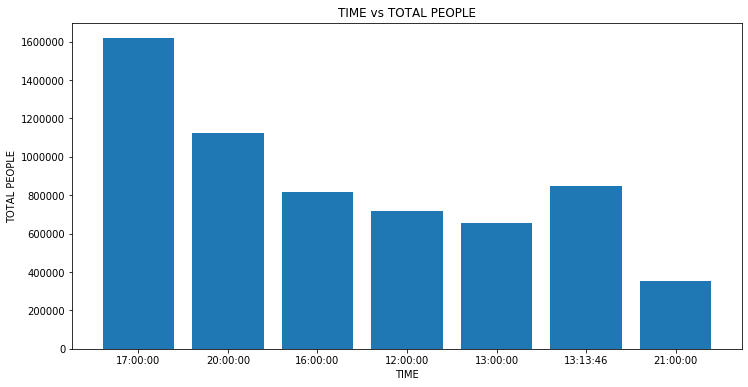

In [99]:
plt.figure(figsize=(12,6))
plt.bar(final_dataframe['TIME'], final_dataframe['TOTAL PEOPLE'])
plt.xlabel('TIME')
plt.ylabel('TOTAL PEOPLE')
plt.title('TIME vs TOTAL PEOPLE');

## Our final recomendations for the top ten stations by weekday and time

In [97]:
final_dataframe = final_dataframe.reset_index()
final_dataframe

,STATION,LINENAME,TIME,day_of_week,TOTAL PEOPLE
0,GRD CNTRL-42 ST,4567S,17:00:00,Thursday,1617716.0
1,34 ST-HERALD SQ,BDFMNQRW,20:00:00,Wednesday,1124593.0
2,TIMES SQ-42 ST,1237ACENQRSW,16:00:00,Friday,816259.0
3,FLUSHING-MAIN,7,12:00:00,Friday,716559.0
4,34 ST-PENN STA,ACE,20:00:00,Wednesday,702138.0
5,14 ST-UNION SQ,LNQR456W,13:00:00,Tuesday,656200.0
6,47-50 STS ROCK,BDFM,20:00:00,Wednesday,595623.0
7,PATH NEW WTC,1,13:13:46,Tuesday,845423.0
8,42 ST-PORT AUTH,ACENQRS1237W,20:00:00,Wednesday,512829.0
9,FULTON ST,2345ACJZ,21:00:00,Tuesday,355537.0
